In [1]:
!pip install dotmap matplotlib

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from dotmap import DotMap
from pathlib import Path
from ddpm import script_utils

In [3]:
def diffusion_defaults():
    defaults = dict(
        num_timesteps=1000,
        schedule="linear",
        loss_type="l2",
        use_labels=False,

        base_channels=128,
        channel_mults=(1, 2, 2, 2),
        num_res_blocks=2,
        time_emb_dim=128 * 4,
        norm="gn",
        dropout=0.1,
        activation="silu",
        attention_resolutions=(1,),

        schedule_low=1e-4,
        schedule_high=0.02,
        
        ema_decay=0.9999,
        ema_update_rate=1,
    )

    return DotMap(defaults)


In [4]:
# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_args = diffusion_defaults()
diffusion = script_utils.get_diffusion_from_args(model_args).to(device)

# Load model
model_path = Path("ddpm_logs/ddpm-2024-09-06-09-38/DDPM-MNIST-32x32-ddpm-2024-09-06-09-38-iteration-50000-model.pth")
if not model_path.exists():
    raise f"Model path {model_path} doesn'nt exists!"
diffusion.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
model = diffusion

In [6]:
from ddpm.utils import extract


def reconstruct_image(model, x, y=None, use_ema=True):
    b, c, h, w = x.shape
    device = x.device

    # Sample a random timestep
    t = torch.randint(0, model.num_timesteps, (b,), device=device)

    # Generate noise
    noise = torch.randn_like(x)

    # Perturb the input image with noise
    perturbed_x = model.perturb_x(x, t, noise)

    # Now denoise the perturbed image step-by-step
    for t_ in range(model.num_timesteps - 1, -1, -1):
        t_batch = torch.tensor([t_], device=device).repeat(b)
        perturbed_x = model.remove_noise(perturbed_x, t_batch, y, use_ema)

        if t_ > 0:
            perturbed_x += extract(model.sigma, t_batch, perturbed_x.shape) * torch.randn_like(perturbed_x)

    return perturbed_x.cpu().detach()

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_images_side_by_side(original_image, reconstructed_image):
    # Convert tensors to PIL images for displaying
    to_pil = T.ToPILImage()

    # Remove batch dimension (B, C, H, W) -> (C, H, W) for display
    original_image = original_image.squeeze(0)  # Assuming it's a batch of 1 image
    reconstructed_image = reconstructed_image.squeeze(0)  # Assuming it's a batch of 1 image

    # Convert to PIL images
    original_pil = to_pil(original_image)
    reconstructed_pil = to_pil(reconstructed_image)

    # Plot both images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_pil)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed_pil)
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')
    
    plt.show()

In [8]:
# Test Dataset
test_dataset = datasets.MNIST(
    root='./mnist_test',
    train=False,
    download=True,
    transform=script_utils.get_transform()
)

/home/s0pex/DDPM/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


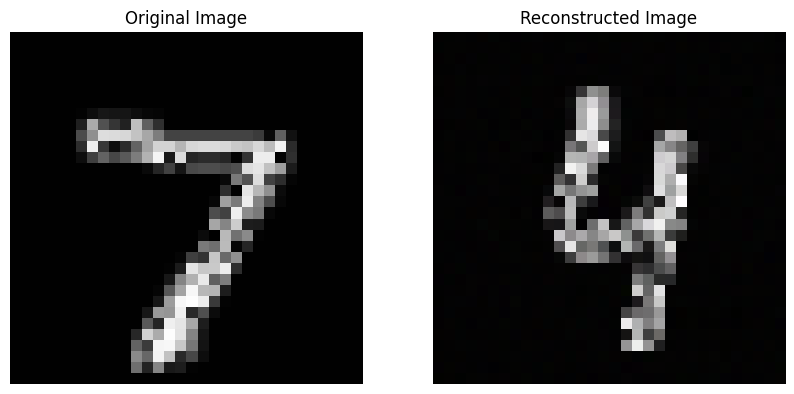

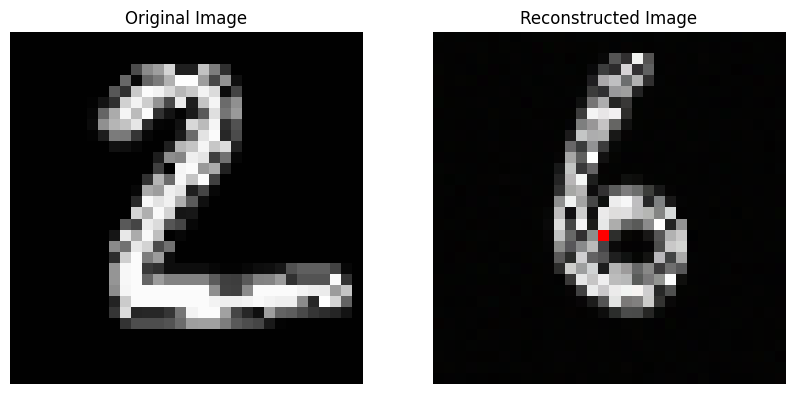

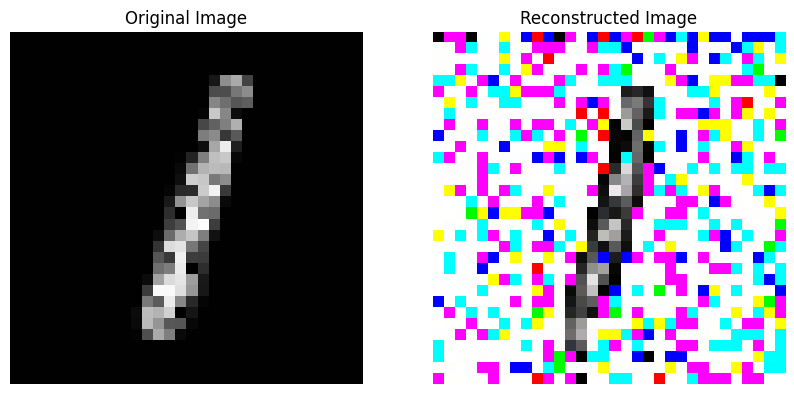

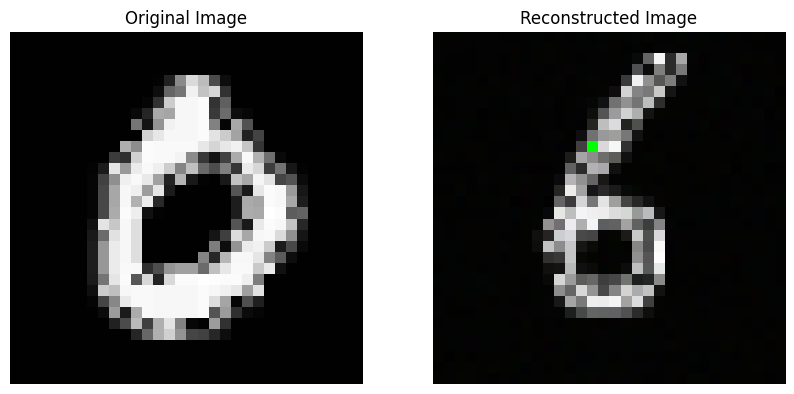

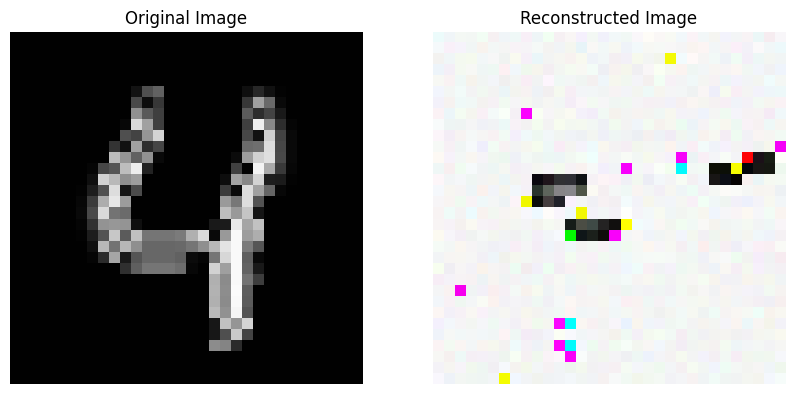

KeyboardInterrupt: 

In [9]:
for (image, indx) in test_dataset:
    # Move Image to device
    image = image.to(device)
    image = image.unsqueeze(0)  # Add batch dimension
    reconstructed_image = reconstruct_image(model, image)
    
    show_images_side_by_side(image, reconstructed_image)